In [1]:
pip install spotipy

Note: you may need to restart the kernel to use updated packages.


# Data Preprocessing

In [4]:
#Goal of project
#1. Take in an audio file
#2. Analyze features of the audio file
#3. Determine which hip-hop artist is most associated/fit for that beat

#General Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import wave
import spotipy
import re
from spotipy.oauth2 import SpotifyClientCredentials


#ML Libraries

import matplotlib.pyplot as plt
import sklearn


# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from math import sqrt


# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout
from tensorflow.keras import initializers

artistsID = r"C:\Users\Pruthvi\Desktop\Beat Classifier\artistsid.csv"



In [5]:
#SETTING UP

#Spotify Auth
cid = "your client id"
secret = "your secret id"

#Creating Spotify Instance
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

df = pd.read_csv(artistsID)
df.head(5)

,Artist,Artist ID
0,NAV,7rkW85dBwwrJtlHRDkJDAC
1,Drake,3TVXtAsR1Inumwj472S9r4
2,Tory Lanez,2jku7tDXc6XoB6MO2hFuqg
3,J. Cole,6l3HvQ5sa6mXTsMTB19rO5
4,Future,1RyvyyTE3xzB2ZywiAwp0i


In [363]:
#REGEX

#re.sub(r'[a-z]+:[a-z]+:', '',sp.artist_top_tracks(artistdf.iloc[0,1], country='US')['tracks'][9]['uri'])

## Processing Song Data From My 50 Most Influential Artists

In [254]:
#Creating Dictionary with
#KEYS: artist names 
#VALUES: dictionary of artist's albums.

AllAlbums ={}
for row in range(len(df)):
    artistName = df.iloc[row,0]
    artistID = df.iloc[row,1]
    artistAlbums = {}
    
    for album in range(len(sp.artist_albums(artistID)['items'])):
        albumName = sp.artist_albums(artistID)['items'][album]['name']
        albumID = sp.artist_albums(artistID)['items'][album]['uri']
        artistAlbums[albumName] = albumID
    AllAlbums[artistName] = artistAlbums


In [258]:
#Create main dataframe with all song names/ids and album names/ids from my top 50 artists.
#Cell might take a while to run!!!
df2 = pd.DataFrame(columns=['Artist', 'Album', 'Album ID', 'Song', 'Song ID'])
for artist in AllAlbums.keys():
    artistDisc = AllAlbums[artist]
    for album in artistDisc.keys():
        albumID = artistDisc[album]
        albumlength = len(sp.album_tracks(artistDisc[album])['items'])
        for song in range(albumlength):
            songname = sp.album_tracks(albumID)['items'][song]['name']
            songid = sp.album_tracks(albumID)['items'][song]['uri']
            
            df2.loc[len(df2.index)] = [artist, album, albumID, songname, songid]

#Drop duplicate songs since deluxe and original versions of an album overlap in songs.            
df2 = df2.drop_duplicates(subset=['Song ID'])

#merge with inital df to get artist IDs.
maindf = df.merge(df2, left_on='Artist', right_on='Artist', how='inner')

In [44]:
#maindf.to_csv(r'C:\Users\Pruthvi\Desktop\Beat Classifier\artistsongs.csv')
maindf = pd.read_csv(r'C:\Users\Pruthvi\Desktop\Beat Classifier\artistsongs.csv')
maindf.head(4)

,Artist,Artist ID,Album,Album ID,Song,Song ID
0,NAV,7rkW85dBwwrJtlHRDkJDAC,Emergency Tsunami (Bonus Version),spotify:album:3aMMFb7DaFT06VfavwhrPi,Breaking News Intro,spotify:track:0Kj67wCgRtCeh2vnnDVRw6
1,NAV,7rkW85dBwwrJtlHRDkJDAC,Emergency Tsunami (Bonus Version),spotify:album:3aMMFb7DaFT06VfavwhrPi,Friends & Family,spotify:track:4NacsqyQU8nZDIdxShKlpU
2,NAV,7rkW85dBwwrJtlHRDkJDAC,Emergency Tsunami (Bonus Version),spotify:album:3aMMFb7DaFT06VfavwhrPi,Young Wheezy (with Gunna),spotify:track:0DZCRBEqV2GYTWj8OPA49H
3,NAV,7rkW85dBwwrJtlHRDkJDAC,Emergency Tsunami (Bonus Version),spotify:album:3aMMFb7DaFT06VfavwhrPi,Nasty,spotify:track:0oAaQfGlKYKHciaZ3OixSh


### Creating Dataframe with all songs and their features
Danceability, energy, key, loudness, mode, acousticness, liveness, valence, tempo, and duration

In [312]:
#Song Features dataframe
#Columns: Artist, Danceability, Energy, Key, 
#Loudness, mode, acousticness, liveness, valence, tempo, duration_ms
#https://medium.com/@FinchMF/praise-questions-and-critique-spotify-api-38e984a4174b    -  explains audio features
featuresdf = pd.DataFrame(columns=['artist', 'danceability', 'energy', 'key', 'loudness', 'mode', 'acousticness',
                                  'liveness', 'valence', 'tempo', 'duration_ms'])
for row in range(len(maindf)):
    artist = maindf.iloc[row,0]
    songID = maindf.iloc[row,5]
    features = sp.audio_features(songID)[0]

    
    featuresdf.loc[len(featuresdf)] = [artist, features['danceability'], features['energy'], 
                                             features['key'], features['loudness'], features['mode'],
                                            features['acousticness'], features['liveness'], features['valence'],
                                       features['tempo'], features['duration_ms']]




Mode describes if a song has a major or minor scale. I will simply turn this feature into two new features, major and minor. This is like one-hot-encoding the categorical mode feature.

In [516]:
featuresdf['major'] = featuresdf['mode']
featuresdf['minor'] = abs(1- featuresdf['mode'])
featuresdf = featuresdf.drop('mode', axis=1)

I am removing artists with less than 100 songs. 

In [1523]:
#featuresdf = pd.read_csv(r'C:\Users\Pruthvi\Desktop\Beat Classifier\songfeatures.csv')

In [1524]:
artistsfrequency = featuresdf.groupby('artist').agg('count').loc[:,'danceability']
artistsfrequency = pd.DataFrame(data = {'artist':artistsfrequency.index,
                                        'frequency':artistsfrequency.loc[:].to_numpy().astype(int)},
                                index = range(50))

In [1517]:
artistsfrequency.head(5)

,artist,frequency
0,2 Chainz,183
1,21 Savage,190
2,88GLAM,98
3,Belly,75
4,Big Sean,160


In [1528]:
featuresdf = featuresdf.merge(artistsfrequency, how='inner', on='artist')
featuresdf = featuresdf.loc[featuresdf['frequency'] >=100,:]

In [1529]:
featuresdf.index = range(len(featuresdf))

In [1530]:
featuresdf = featuresdf.drop(['frequency'],axis=1)

In [1531]:
featuresdf

,artist,danceability,energy,key,loudness,acousticness,liveness,valence,tempo,duration_ms,major,minor
0,NAV,0.721,0.684,5,-10.378,0.93700,0.9010,0.913,126.958,34936,1,0
1,NAV,0.835,0.509,1,-6.792,0.03420,0.1400,0.275,129.077,145121,1,0
2,NAV,0.918,0.544,6,-3.749,0.01220,0.0850,0.311,122.017,151481,0,1
3,NAV,0.955,0.619,5,-5.242,0.03170,0.1080,0.524,116.026,157242,0,1
4,NAV,0.788,0.778,11,-4.931,0.00218,0.1440,0.543,159.995,159004,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6054,2 Chainz,0.732,0.729,9,-2.955,0.14900,0.5080,0.690,128.968,253200,0,1
6055,2 Chainz,0.823,0.612,11,-5.832,0.08420,0.1100,0.537,96.989,199160,1,0
6056,2 Chainz,0.776,0.427,1,-11.808,0.02460,0.0882,0.891,132.192,230280,1,0
6057,2 Chainz,0.727,0.632,9,-11.110,0.03410,0.0829,0.635,148.553,219227,0,1


In [1535]:
#featuresdf.to_csv(r'C:\Users\Pruthvi\Desktop\Beat Classifier\songfeaturesartistfiltered.csv')

In [17]:
featuresdf = pd.read_csv(r'C:\Users\Pruthvi\Desktop\Beat Classifier\songfeaturesartistfiltered.csv')

### Creating Song and Feature Dataframe For My Beats

In [1303]:
myBeats = {}
beatTapeID = "6jojGLvkUS27x2T0Nmg8yw"
for song in range(10):
    beatName = sp.album_tracks(beatTapeID)['items'][song]['name']
    beatID = sp.album_tracks(beatTapeID)['items'][song]['uri']
    myBeats[beatName] = beatID

myfeaturesdf = pd.DataFrame(columns=['Beat Name', 'danceability', 'energy', 'key', 'loudness', 'mode', 'acousticness',
                                  'liveness', 'valence', 'tempo', 'duration_ms'])

for eachSong in myBeats.keys():
    features = sp.audio_features(myBeats[eachSong])[0]
    myfeaturesdf.loc[len(myfeaturesdf)] = [eachSong, features['danceability'], features['energy'], 
                                             features['key'], features['loudness'], features['mode'],
                                            features['acousticness'], features['liveness'], features['valence'],
                                       features['tempo'], features['duration_ms']]
    
myfeaturesdf['major'] = myfeaturesdf['mode']
myfeaturesdf['minor'] = abs(1- myfeaturesdf['mode'])
myfeaturesdf = myfeaturesdf.drop('mode', axis=1)

\* When exporting dataframe to csv, there will be an extra index column created in the most left row of the spreadsheet. You can easily manually remove it.

In [1308]:
#myfeaturesdf.to_csv(r'C:\Users\Pruthvi\Desktop\Beat Classifier\mybeatfeatures.csv')

In [1309]:
myfeaturesdf = pd.read_csv(r'C:\Users\Pruthvi\Desktop\Beat Classifier\mybeatfeatures.csv')

# Creating Keras Classification Model

Important Note: This model will be evaluated qualitatively at the end. It will be trained on the gathered songs, with the X matrix being the song's relevant features and the Y matrix being the artist. In the end, the model should be able to handle a series of audio features and output which artist is most closely associated with the features. 

### Binary Classification
I will start with a simpler version of this project: Binary Classification. Specifically, I will classify my beats between two of my top, randomly-selected artists: NAV and Drake. Afterwards, I'll scale up the architecture of the ANN and try it with more artists, till I can reach them all.

In [18]:
featuresdf = pd.read_csv(r'C:\Users\Pruthvi\Desktop\Beat Classifier\songfeaturesartistfiltered.csv')

#### Preparing X and Y matrices

In [19]:
featuresdf.head(324)
preBinaryX = featuresdf.iloc[:324,1:]
preBinaryY = featuresdf.iloc[:324,0]

In [20]:
X = preBinaryX.to_numpy()
Y = [0 if y == 'NAV' else 1 for y in preBinaryY.to_numpy()]
Y = to_categorical(Y)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)

In [22]:
#We are transforming x_test by X_train's mean and sd so that the test set is in the same terms/"basis" as 
#the training set.

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



#### Building the Binary Model

In [36]:
model_binary = Sequential()
model_binary.add(Dense(32, input_dim=11, activation='relu'))
model_binary.add(Dropout(0.4))
model_binary.add(Dense(32, activation='relu'))
model_binary.add(Dense(2, activation='softmax'))

filepath=r"C:\Users\Pruthvi\Desktop\Beat Classifier"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

sgd = SGD(lr=0.001)

In [37]:
model_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
history = model_binary.fit(X_train, y_train, verbose=0,epochs=600, batch_size=200, callbacks=callbacks_list, validation_split=0.15)

INFO:tensorflow:Assets written to: C:\Users\Pruthvi\Desktop\Beat Classifier\assets
INFO:tensorflow:Assets written to: C:\Users\Pruthvi\Desktop\Beat Classifier\assets
INFO:tensorflow:Assets written to: C:\Users\Pruthvi\Desktop\Beat Classifier\assets
INFO:tensorflow:Assets written to: C:\Users\Pruthvi\Desktop\Beat Classifier\assets
INFO:tensorflow:Assets written to: C:\Users\Pruthvi\Desktop\Beat Classifier\assets
INFO:tensorflow:Assets written to: C:\Users\Pruthvi\Desktop\Beat Classifier\assets
INFO:tensorflow:Assets written to: C:\Users\Pruthvi\Desktop\Beat Classifier\assets
INFO:tensorflow:Assets written to: C:\Users\Pruthvi\Desktop\Beat Classifier\assets
INFO:tensorflow:Assets written to: C:\Users\Pruthvi\Desktop\Beat Classifier\assets
INFO:tensorflow:Assets written to: C:\Users\Pruthvi\Desktop\Beat Classifier\assets
INFO:tensorflow:Assets written to: C:\Users\Pruthvi\Desktop\Beat Classifier\assets
INFO:tensorflow:Assets written to: C:\Users\Pruthvi\Desktop\Beat Classifier\assets


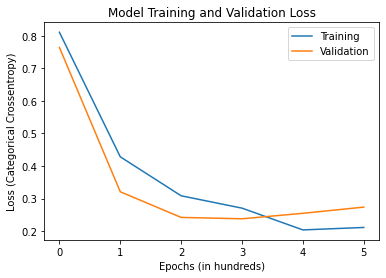

In [39]:
plt.title("Model Training and Validation Loss")
plt.xlabel("Epochs (in hundreds)")
plt.ylabel("Loss (Categorical Crossentropy)")
plt.plot(history.history['loss'][::100])
plt.plot(history.history['val_loss'][::100])
plt.legend(labels=['Training', 'Validation']);

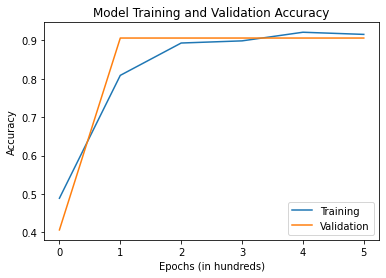

In [40]:
plt.title("Model Training and Validation Accuracy")
plt.xlabel("Epochs (in hundreds)")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'][::100])
plt.plot(history.history['val_accuracy'][::100])
plt.legend(labels=['Training', 'Validation']);

I am using validation accuracy over validation loss for determining when to stop training. This is because the low point of my validation loss isn't my best accuracy and my overall goal is to improve accuracy. 

#### Evaluating Binary Model Further

I am calcuating the accuracy of the model across a 1000 randomly generated test/train sets to see how the model generalizes and to test the accuracy from earlier training.

In [30]:
def calculate_acc(X_test, y_test, model):
    correct = 0
    predictions = model.predict(X_test)
    for index in range(1, len(X_test)):
        if predictions[index][0] > predictions[index][1] and y_test[index][0] == 1:
            correct+=1
        elif predictions[index][1] > predictions[index][0] and y_test[index][1] == 1:
            correct+=1
    return correct/len(predictions)
    
    


In [32]:
model_eval = keras.models.load_model(r"C:\Users\Pruthvi\Desktop\Beat Classifier\BinaryModelDrakeandNAV\binaryclassificationninetyfour.h5")

In [33]:
trainaccuracy = []
testaccuracy = []
for h in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35)
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)
    trainaccuracy += [calculate_acc(X_train, y_train, model_eval)]
    testaccuracy += [calculate_acc(X_test, y_test, model_eval)]



0.922161904761905


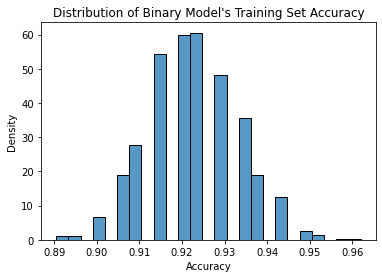

In [34]:
print(np.mean(trainaccuracy))
sns.histplot(trainaccuracy, stat='density')
plt.xlabel("Accuracy")
plt.title("Distribution of Binary Model's Training Set Accuracy");



0.9166228070175438


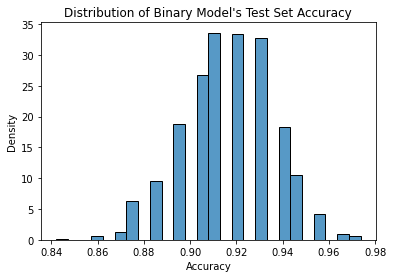

In [35]:
print(np.mean(testaccuracy))
sns.histplot(testaccuracy, stat='density')
plt.title("Distribution of Binary Model's Test Set Accuracy")
plt.xlabel('Accuracy');

To save binary model:

In [1413]:
#model_binary.save(r'C:\Users\Pruthvi\Desktop\Beat Classifier\ninetyfour.h5')

In summary, this binary model, which classifies music as being closer to NAV or Drake's music, is able to do so with around ~92% accuracy when compared across 1000 samples. Now we will work with the entire subset of artists. Several key things I learned through this process of building a binary classifier:

1. Tradeoff between model complexity and generality for ensuring similar accuracy between training and testing sets.
2. Importance of standardizing the data after test-train-split. Allows model to reach "global" minimum and far quicker.
3. Increasing the batch-size allows the model to start off with higher accuracy and train faster overall (less epochs). I also got a higher accuracy across my test and training sets.
4. Keep track of accuracy across test and training sets and test several times since accuracy varies across samples.

In [1198]:
#model = load_model(r"C:\Users\Pruthvi\Desktop\Beat Classifier\ninetythree.h5")

### Full Multiclass Classifier (The Beginning)

#### *Quick Changes

After testing different architecture/hyperparameters on the A.N.N. model, I realized that to achieve a high accuracy, there needs to be more data per artist. Hence, I will group related artists using help from the "Spotify Related Artists" feature and personal preference (considering recent collaborations between artists). This is increase the datapoints per group and decrease the overall number of groups.


In [7]:
sp.artist_related_artists('0c173mlxpT3dSFRgMO8XPh')['artists'][8]['name']

'Pusha T'

#### Grouping artists

In [6]:
def groupartists(names):
    for index in range(len(names)):
        if names[index] == "YG" or names[index] == "Tyga":
            names[index] ="YG x Tyga"
        
        elif names[index] == "Young Thug" or names[index] == "Future":
            names[index] = "Young Thug x Future"
        
        elif names[index] == "Meek Mill" or names[index] == "Lil Durk":
            names[index] = "Meek Mill x Lil Durk"
        
        elif names[index] == "Juicy J" or names[index] == "2 Chainz":
            names[index] = "Juicy J x 2 Chainz"
        
        elif names[index] == "Eminem" or names[index] == "Logic":
            names[index] = "Eminem x Logic"
        
        elif names[index] == "NAV" or names[index] == "Lil Uzi Vert":
            names[index] = "NAV x Lil Uzi Vert"
        
        elif names[index] == "Kid Cudi" or names[index] == "Jaden":
            names[index] = "Kid Cudi x Jaden"
        
        elif names[index] == "J. Cole" or names[index] == "21 Savage":
            names[index] = "J. Cole x 21 Savage"
        
        elif names[index] == "Lil Wayne" or names[index] == "DJ Khaled":
            names[index] = "Lil Wayne x DJ Khaled"
        
        elif names[index] == "The Weeknd" or names[index] == "Post Malone":
            names[index] = "The Weeknd x Post Malone"
        
        elif names[index] == "Kevin Gates" or names[index] == "Gucci Mane":
            names[index] = "Kevin Gates x Gucci Mane"
        
        elif names[index] == "Kanye West" or names[index] == "Big Sean":
            names[index] = "Kanye West x Big Sean"
            
        elif names[index] == "Tory Lanez" or names[index] == "DaBaby":
            names[index] = "Tory Lanez x Dababy"
            
        elif names[index] == "Russ" or names[index] == "Ty Dolla Sign":
            names[index] = "Russ x Ty Dolla Sign"
            
        elif names[index] == "Iamsu!" or names[index] == "G-Eazy":
            names[index] = "Iamsu! x G-Eazy"
        
    return names    
        
    

In [45]:
featuresdf = pd.read_csv(r'C:\Users\Pruthvi\Desktop\Beat Classifier\songfeaturesartistfiltered.csv')

In [46]:
artistlabels = featuresdf['artist']

In [47]:
artistlabels1 = groupartists(artistlabels)

<ipython-input-6-f20ecc94eaaf>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  names[index] = "NAV x Lil Uzi Vert"
<ipython-input-6-f20ecc94eaaf>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  names[index] = "Tory Lanez x Dababy"
<ipython-input-6-f20ecc94eaaf>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  names[index] = "J. Cole x 21 Savage"
<ipython-input-6-f20ecc94eaaf>:7: SettingWithCopyWarning: 
A value is trying to be set

In [48]:
artistlabels1.value_counts()

Kevin Gates x Gucci Mane    432
Juicy J x 2 Chainz          427
Iamsu! x G-Eazy             416
Young Thug x Future         393
Meek Mill x Lil Durk        386
J. Cole x 21 Savage         380
YG x Tyga                   375
Russ x Ty Dolla Sign        375
Lil Wayne x DJ Khaled       373
Kanye West x Big Sean       340
Nipsey Hussle               301
Tory Lanez x Dababy         284
Eminem x Logic              283
Kid Cudi x Jaden            273
NAV x Lil Uzi Vert          265
The Weeknd x Post Malone    243
Drake                       181
French Montana              175
Wiz Khalifa                 157
Name: artist, dtype: int64

In [49]:
featuresdf['artist'] = artistlabels1

In [51]:
featuresdf.head(5)

,artist,danceability,energy,key,loudness,acousticness,liveness,valence,tempo,duration_ms,major,minor
0,NAV x Lil Uzi Vert,0.721,0.684,5,-10.378,0.93700,0.901,0.913,126.958,34936,1,0
1,NAV x Lil Uzi Vert,0.835,0.509,1,-6.792,0.03420,0.140,0.275,129.077,145121,1,0
2,NAV x Lil Uzi Vert,0.918,0.544,6,-3.749,0.01220,0.085,0.311,122.017,151481,0,1
3,NAV x Lil Uzi Vert,0.955,0.619,5,-5.242,0.03170,0.108,0.524,116.026,157242,0,1
4,NAV x Lil Uzi Vert,0.788,0.778,11,-4.931,0.00218,0.144,0.543,159.995,159004,0,1


In [15]:
featuresdf.to_csv(r'C:\Users\Pruthvi\Desktop\Beat Classifier\fullclassifierdataset.csv')

#### Preparing X and Y matrices

In [285]:
#X-matrix
X = featuresdf.iloc[:,1:].to_numpy()

In [286]:
X.shape

(6059, 11)

In [287]:
#Y-matrix

#One-hot-encoding
Y_cat = featuresdf['artist']
encoder = LabelEncoder()
encoder.fit(Y_cat)
Y_encoded = encoder.transform(Y_cat)
Y = to_categorical(Y_encoded)
Y.shape

(6059, 19)

In [293]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, Y, test_size=0.30)

In [294]:
#Standardize X
sc = StandardScaler()
X_train_full = sc.fit_transform(X_train_full)
X_test_full = sc.transform(X_test_full)

I will be using a GridSearch to find the ideal hyperparameters for my model.

#### GridSearch

In [383]:
def create_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes, input_dim=11, activation=activation))
            model.add(Dropout(0.3))
        else:
            model.add(Dense(nodes, kernel_initializer='he_normal', activation=activation))
            model.add(Dropout(0.3))
    
    model.add(Dense(units = 19, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            
    return model
    

In [384]:
model_full = KerasClassifier(build_fn=create_model, verbose=2)

In [385]:
layers = [(64,32,16), (1024, 512), (128, 64, 32, 16), (16, 16, 16, 16, 16), (64, 32, 16, 16, 8), 
          (128, 64, 32, 16, 8), (4096,)]

activations = ['relu']

batch_sizes = (256, 512, 1024, 2048, 4096)

epochs = [6000]

param_grid = {'layers': layers, 'activation': activations, 'batch_size': batch_sizes, 'epochs': epochs}

theGrid = GridSearchCV(estimator=model_full, param_grid=param_grid,cv=5)

 Running this code in the Jupyter Notebook isn't feasible. Local machines can't handle a large grid search like this. 

### Hence we move to Google Colab and use a GPU!

In [ ]:
###Don't run this cell!!!
#best_model = theGrid.fit(X_train_full, y_train_full)